In [1]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision

from __future__ import print_function, division
from builtins import range,input


# In this script, we will focus on generating the content
# E.g. given an image, can we recreate the same image
from keras.layers import Input,Lambda, Dense,Flatten
from keras.layers import AveragePooling2D,MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b




Using TensorFlow backend.


- Image path: http://www.vision.caltech.edu/Image_Datasets/Caltech101/

- VGG16_AvgPool: 將Max Pool換成 Avg Pool 以保留較多圖片訊息
- VGG16_AvgPool_CutOff: 選擇應用到第幾層Conv Layer


In [2]:
# we want to account for features across the entire image
# so get rid of the maxpool which throws away information
# 將max pool 換成average pool
def VGG16_AvgPool(shape):
    vgg = VGG16(input_shape =shape,weights = 'imagenet',include_top = False)
    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
        # replace it with average pooling
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
            
    return new_model

# there are 13 convolutions in total, we can pick any of them as the "output" of our content model
def VGG16_AvgPool_CutOff(shape,num_convs):
    if num_convs<1 or num_convs >12:
        print("num_convs must be in the range [1,13]")
        return None
    
    
    model = VGG16_AvgPool(shape)
    new_model = Sequential()
    
    n = 0
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n = n+1
        new_model.add(layer)
        if n >= num_convs:
            break
            
    return new_model


def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img


def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

   

#### 1.  Make content Model

 - try different cutoffs to see the images that result
 - K.variable: instantiates a variable
 
 
 - Can change from 1 to 13, see what's the difference

In [3]:
if __name__ == '__main__':
    path ='data_NST/content/image_0002.jpg'
    img = image.load_img(path)
    # open an image
    # path = '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg'
    
    # convert image to array and preprocess for vgg
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis = 0)
    x = preprocess_input(x)
    
    # we'll use this throughout the rest of the script
    batch_shape = x.shape
    shape = x.shape[1:]
    
    # see the image
    #plt.imshow(img)
    #plt.show()
    
    
content_model = VGG16_AvgPool_CutOff(shape,11)

# make the target
target = K.variable(content_model.predict(x))

# try to match the image

# define our loss in keras
loss = K.mean(K.square(target-content_model.output))

## gradients which are needed by the optimizer

grads = K.gradients(loss,content_model.input)

# just like theano.function

get_loss_and_grads = K.function(
    inputs = [content_model.input],
    outputs = [loss]+grads)

def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise  
    l,g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64),g.flatten().astype(np.float64)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


- clip这个函数将将数组中的元素限制在a_min, a_max之间，大于a_max的就使得它等于 a_max，小于a_min,的就使得它等于a_min。

iter = 0, loss = 23.072021484375
iter = 1, loss = 9.362824440002441
iter = 2, loss = 5.668806076049805
iter = 3, loss = 4.056761264801025
iter = 4, loss = 3.221000909805298
iter = 5, loss = 2.6721787452697754
iter = 6, loss = 2.2909157276153564
iter = 7, loss = 2.032008647918701
iter = 8, loss = 1.8051624298095703
iter = 9, loss = 1.6194062232971191
duration: 0:00:25.373568


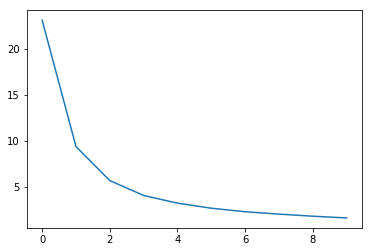

In [4]:
from datetime import datetime
t0 = datetime.now()

losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
    x,l,_ = fmin_l_bfgs_b(
    func = get_loss_and_grads_wrapper,
    x0 = x,
    maxfun = 20)
    
    x = np.clip(x,-127,127)
    print("iter = %s, loss = %s" % (i,l))
    losses.append(l)
    
print("duration:",datetime.now()-t0)
plt.plot(losses)
plt.show()


    

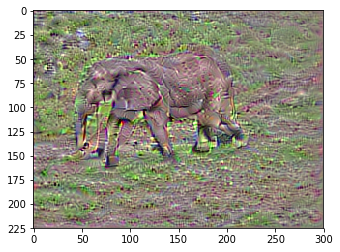

In [5]:
newing = x.reshape(*batch_shape)
final_img = unpreprocess(newing)


plt.imshow(scale_img(final_img[0]))
plt.show()

#### 2. Make Style Model

- K.batch_flatten: Turn a nD tensor into a 2D tensor with same 0th dimension.

In [6]:
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
    G = K.dot(X,K.transpose(X))/img.get_shape().num_elements()
    return G

def style_loss(y,t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

# let's generalize this and put it into a function

def minimize(fn,epochs,batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x,l,_ = fmin_l_bfgs_b(
        func = fn,
        x0 = x,
        maxfun = 20
        )
        
        x = np.clip(x,-127,127)
        print("iter = %s, loss = %s"% (i,l))
        losses.append(l)
        
    print('duration:',datetime.now() - t0)
    plt.plot(losses)
    plt.show()
    
    
    newing = x.reshape(*batch_shape)
    final_img = unpreprocess(newing)
    return final_img[0]


Instructions for updating:
keep_dims is deprecated, use keepdims instead
iter = 0, loss = 9696.478515625
iter = 1, loss = 414.0013122558594
iter = 2, loss = 162.9723358154297
iter = 3, loss = 110.17683410644531
iter = 4, loss = 78.15852355957031
iter = 5, loss = 60.41463088989258
iter = 6, loss = 43.84054946899414
iter = 7, loss = 31.096782684326172
iter = 8, loss = 23.714557647705078
iter = 9, loss = 17.551694869995117
duration: 0:01:02.672376


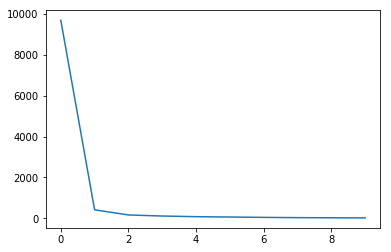

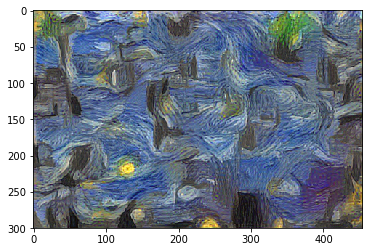

In [7]:

if __name__ == '__main__':
   # try these, or pick your own!
    path = 'data_NST/style/starrynight.jpg'
    
    # load the data
    img = image.load_img(path)
    # convert image to array and preprocess for vgg
    x = image.img_to_array(img)
  # look at the image
    #plt.imshow(x)
    #plt.show()
    
     # make it (1, H, W, C)   
    x = np.expand_dims(x,axis = 0)
    # preprocess into VGG expected format
    x = preprocess_input(x)
    
    # we'll use this throughout the rest of the script
    batch_shape = x.shape
    shape = x.shape[1:]
    
  # let's take the first convolution at each block of convolutions
  # to be our target outputs
  # remember that you can print out the model summary if you want 
    vgg = VGG16_AvgPool(shape)
    
   # Note: need to select output at index 1, since outputs at
  # index 0 correspond to the original vgg with maxpool
    
    symbolic_conv_outputs = [
        layer.get_output_at(1) for layer in vgg.layers
        if layer.name.endswith('conv1')
    ]
   
  # pick the earlier layers for
  # a more "localized" representation
  # this is opposed to the content model
  # where the later layers represent a more "global" structure
  # symbolic_conv_outputs = symbolic_conv_outputs[:2]
    
  # make a big model that outputs multiple layers' outputs
    multi_output_model = Model(vgg.input,symbolic_conv_outputs)
  # calculate the targets that are output at each layer  
    style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]
    
    loss = 0
    for symbolic,actual in zip(symbolic_conv_outputs,style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
        loss +=style_loss(symbolic[0],actual[0])
        
    grads = K.gradients(loss,multi_output_model.input)
    
    get_loss_and_grads = K.function(
        inputs = [multi_output_model.input],
        outputs = [loss]+grads)
    
    def get_loss_and_grads_wrapper(x_vec):
        l,g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
        return l.astype(np.float64), g.flatten().astype(np.float64)
    
    
    final_img = minimize(get_loss_and_grads_wrapper,10,batch_shape)
    plt.imshow(scale_img(final_img))
    plt.show()
        
        
    
    